In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

#### Load data

In [2]:
xy = np.loadtxt("xy.txt").T
xydot = np.loadtxt("xydot.txt").T

In [3]:
# Split data
x = xy[:, 0]
y = xy[:, 1]
x_dot = xydot[:, 0]
y_dot = xydot[:, 1]

#### Define polynomial library functions this create polynomial features up to specified degree

In [5]:
def create_polynomial_features(X, degree=3):
    n_samples = X.shape[0]
    features = []
    feature_names = []
    
    for deg in range(degree+1):
        for powers in combinations_with_replacement(range(2), deg):
            # Count powers for each variable
            p = np.zeros(2, dtype=int)
            for var in powers:
                p[var] += 1
                
            # Create name for this feature
            if np.sum(p) == 0:
                name = '1'
            else:
                terms = []
                if p[0] > 0:
                    if p[0] == 1:
                        terms.append('x')
                    else:
                        terms.append(f'x^{p[0]}')
                if p[1] > 0:
                    if p[1] == 1:
                        terms.append('y')
                    else:
                        terms.append(f'y^{p[1]}')
                name = '*'.join(terms)
            
            # Compute feature values
            feature = np.ones(n_samples)
            for i, d in enumerate(p):
                if d > 0:
                    feature *= np.power(X[:, i], d)
                    
            features.append(feature)
            feature_names.append(name)
    
    return np.column_stack(features), feature_names

####  Apply SINDy to reconstruct the ODE

In [11]:
print("Part (a): Applying SINDy to reconstruct the ODE")
print("------------------------------------------------")

# Apply SINDy to discover governing equations, X: state data [x, y], X_dot: derivative data [x_dot, y_dot]
def sindy(X, X_dot, degree=3, threshold=1e-5):
    
    # Create library of polynomial functions
    Theta, feature_names = create_polynomial_features(X, degree)
    
    # For each dimension, solve least squares problem
    Xi = np.zeros((Theta.shape[1], X_dot.shape[1]))
    for i in range(X_dot.shape[1]):
        # Solve least squares: Theta * Xi[:, i] = X_dot[:, i]
        Xi[:, i] = np.linalg.lstsq(Theta, X_dot[:, i], rcond=None)[0]
        
        # Apply threshold for sparsity
        Xi[np.abs(Xi[:, i]) < threshold, i] = 0
    
    return Xi, feature_names

# Apply SINDy
X = np.column_stack((x, y))
X_dot = np.column_stack((x_dot, y_dot))
Xi, feature_names = sindy(X, X_dot, degree=3, threshold=1e-5)

# Print results
print("Coefficients of P (x_dot):")
for name, coef in zip(feature_names, Xi[:, 0]):
    if abs(coef) > 1e-5:
        print(f"{name}: {coef}")

print("\nCoefficients of Q (y_dot):")
for name, coef in zip(feature_names, Xi[:, 1]):
    if abs(coef) > 1e-5:
        print(f"{name}: {coef}")

Part (a): Applying SINDy to reconstruct the ODE
------------------------------------------------
Coefficients of P (x_dot):
y: -0.49999999999984474
y^3: 0.49999999999920974

Coefficients of Q (y_dot):
x: 0.9999999999998325
x^3: -0.9999999999994041


#### Plot original vector field

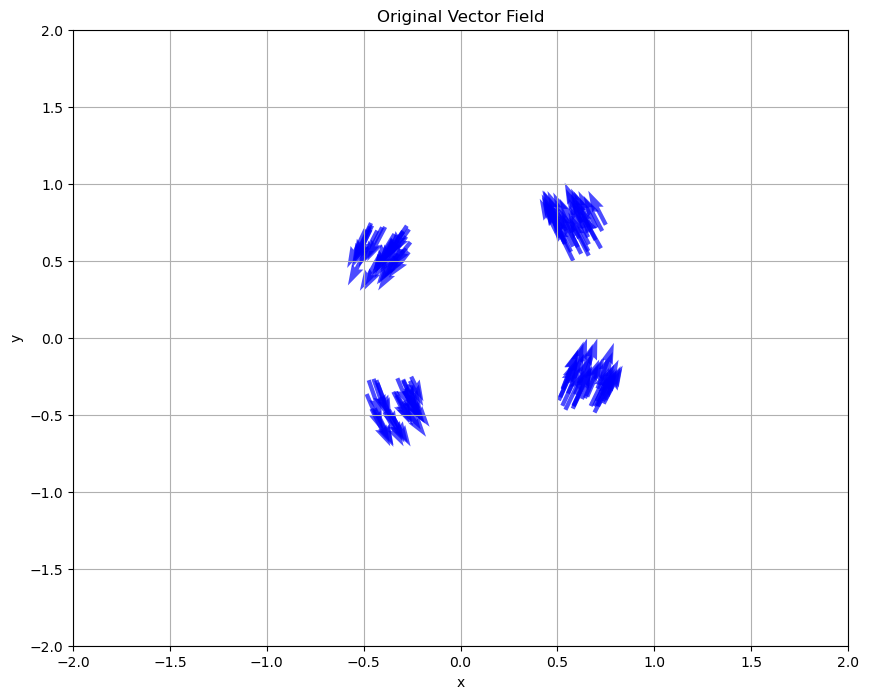

In [14]:
plt.figure(figsize=(10, 8))
plt.quiver(x, y, x_dot, y_dot, color='blue', alpha=0.7)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Vector Field')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

#### Using Euler method to reconstruct trajectories


Part (b): Using Euler method to reconstruct trajectories
------------------------------------------------------


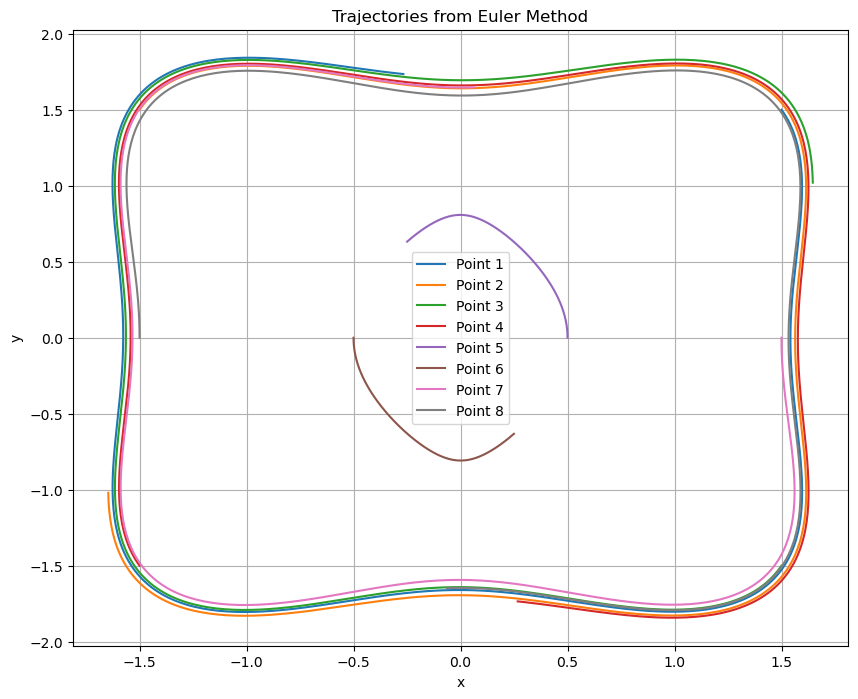

Generated trajectories for 8 points using Euler method with dt=0.01


In [19]:
print("\nPart (b): Using Euler method to reconstruct trajectories")
print("------------------------------------------------------")

def evaluate_polynomial(Xi, x, y, feature_names):
    """Evaluate the polynomial at point (x,y)"""
    result = np.zeros(Xi.shape[1])
    
    for i, name in enumerate(feature_names):
        # Parse feature name to get powers
        value = 1.0
        if name == '1':
            pass  # Value remains 1
        elif 'x' in name and 'y' in name:
            if '^' in name.split('*')[0]:
                x_power = int(name.split('*')[0].split('^')[1])
            else:
                x_power = 1
                
            if '^' in name.split('*')[1]:
                y_power = int(name.split('*')[1].split('^')[1])
            else:
                y_power = 1
                
            value = x**x_power * y**y_power
        elif 'x' in name:
            if '^' in name:
                x_power = int(name.split('^')[1])
            else:
                x_power = 1
            value = x**x_power
        elif 'y' in name:
            if '^' in name:
                y_power = int(name.split('^')[1])
            else:
                y_power = 1
            value = y**y_power
            
        for j in range(Xi.shape[1]):
            result[j] += Xi[i, j] * value
            
    return result

def euler_method(initial_points, t_end, dt, Xi, feature_names):
    """
    Euler method to simulate trajectories
    """
    n_points = initial_points.shape[0]
    n_steps = int(t_end / dt)
    trajectories = np.zeros((n_points, n_steps+1, 2))
    
    # Set initial conditions
    trajectories[:, 0, :] = initial_points
    
    # Euler steps
    for i in range(n_steps):
        for j in range(n_points):
            x, y = trajectories[j, i]
            derivatives = evaluate_polynomial(Xi, x, y, feature_names)
            
            # Update using Euler method
            trajectories[j, i+1, 0] = x + dt * derivatives[0]
            trajectories[j, i+1, 1] = y + dt * derivatives[1]
    
    return trajectories

# Define initial points as specified
initial_points = np.array([
    [1.5, 1.5], [-1.5, 1.5], [1.5, -1.5], [-1.5, -1.5],
    [0.5, 0], [-0.5, 0], [1.5, 0], [-1.5, 0]
])

# Run Euler method
t_end = 5
dt = 0.01
trajectories = euler_method(initial_points, t_end, dt, Xi, feature_names)

# Plot trajectories
plt.figure(figsize=(10, 8))
for i in range(trajectories.shape[0]):
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], label=f'Point {i+1}')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories from Euler Method')
plt.legend()
plt.show()

print(f"Generated trajectories for {initial_points.shape[0]} points using Euler method with dt={dt}")

#### Find approximation to Koopman operator

In [22]:
print("\nPart (c): Finding approximation to Koopman operator")
print("---------------------------------------------------")

# Create library for Koopman operator approximation
def create_koopman_library(X, degree=5):
    return create_polynomial_features(X, degree)

# Create Koopman library for states and next states
Phi, phi_features = create_koopman_library(X, degree=5)

# Compute next states using Euler method
X_next = X + dt * X_dot
Phi_next, _ = create_koopman_library(X_next, degree=5)

# Compute Koopman operator K using pseudoinverse
# The equation is: Phi_next = Phi * K
# So K = Phi^+ * Phi_next where Phi^+ is the pseudoinverse of Phi
Phi_pinv = np.linalg.pinv(Phi)
K = Phi_pinv @ Phi_next

# Check determinant
det_K = np.linalg.det(K)
print(f"Determinant of Koopman matrix K: {det_K}")

# If determinant is outside desired range, adjust dt and recompute
if det_K < 1e-5 or det_K > 1e5:
    print("Adjusting dt to get better conditioned Koopman matrix...")
    
    # Try different dt values
    dt_values = [0.001, 0.005, 0.0075, 0.01, 0.025, 0.05]
    
    for dt_trial in dt_values:
        X_next_trial = X + dt_trial * X_dot
        Phi_next_trial, _ = create_koopman_library(X_next_trial, degree=5)
        K_trial = np.linalg.pinv(Phi) @ Phi_next_trial
        det_K_trial = np.linalg.det(K_trial)
        
        print(f"dt={dt_trial}, det(K)={det_K_trial}")
        
        if 1e-5 < det_K_trial < 1e5:
            print(f"Selected dt={dt_trial}")
            dt = dt_trial
            K = K_trial
            det_K = det_K_trial
            break


Part (c): Finding approximation to Koopman operator
---------------------------------------------------
Determinant of Koopman matrix K: 1.0000977982557104


#### Compute eigenvalues and eigenvectors


Part (d): Computing eigenvalues and eigenvectors
------------------------------------------------
Absolute values of eigenvalues:
[1.00767805 1.00767805 1.00324071 1.00324071 1.00198541 1.00198541
 1.00141332 1.00141332 1.00076792 1.00076792 1.         0.99992317
 0.99992317 0.9999218  0.9999218  0.99812137 0.99812137 0.99599436
 0.99599436 0.99256682 0.98961611]


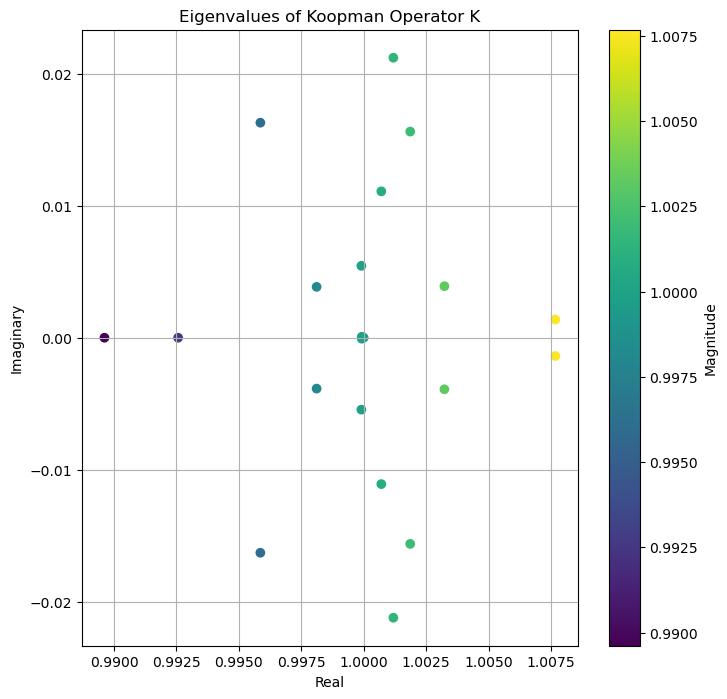

In [26]:
print("\nPart (d): Computing eigenvalues and eigenvectors")
print("------------------------------------------------")

# Compute eigendecomposition
eigenvalues, right_eigenvectors = np.linalg.eig(K)
left_eigenvectors = np.linalg.eig(K.T)[1]  # Left eigenvectors of K

# Sort by eigenvalue magnitude
idx = np.argsort(np.abs(eigenvalues))[::-1]
eigenvalues = eigenvalues[idx]
right_eigenvectors = right_eigenvectors[:, idx]
left_eigenvectors = left_eigenvectors[:, idx]

# Print eigenvalues
print("Absolute values of eigenvalues:")
print(np.abs(eigenvalues))

# Plot eigenvalues on complex plane
plt.figure(figsize=(8, 8))
plt.scatter(eigenvalues.real, eigenvalues.imag, c=np.abs(eigenvalues), cmap='viridis')
plt.colorbar(label='Magnitude')
plt.grid(True)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Eigenvalues of Koopman Operator K')
plt.show()

####  Plot eigenfunctions of Koopman operator


Part (e): Plotting eigenfunctions of Koopman operator
----------------------------------------------------
Found 3 real eigenvalues
Plotting eigenfunction for eigenvalue λ=0.9999999999999949


/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/2209046284.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  Z[i, j] = evaluate_eigenfunction(right_eigenvector,


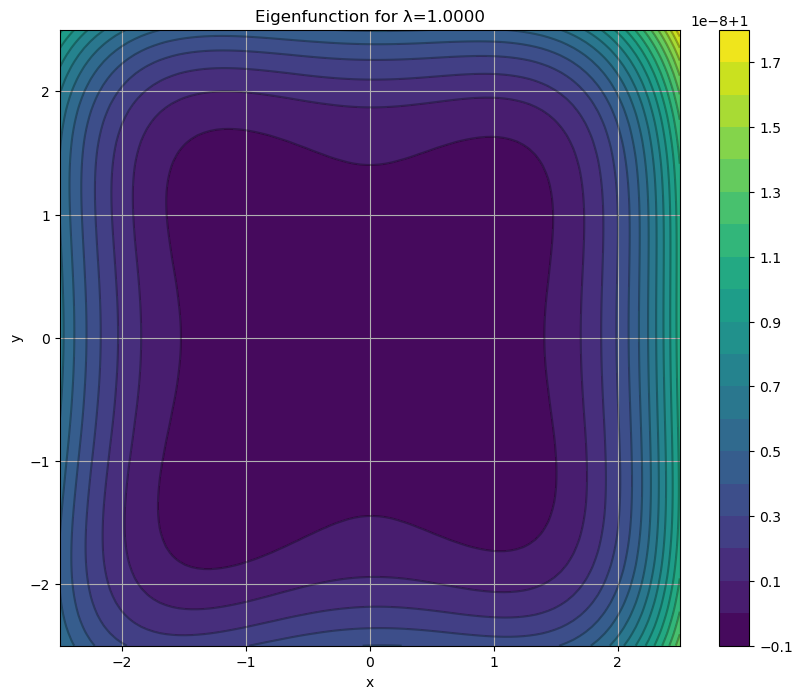

Plotting eigenfunction for eigenvalue λ=0.992566821821185


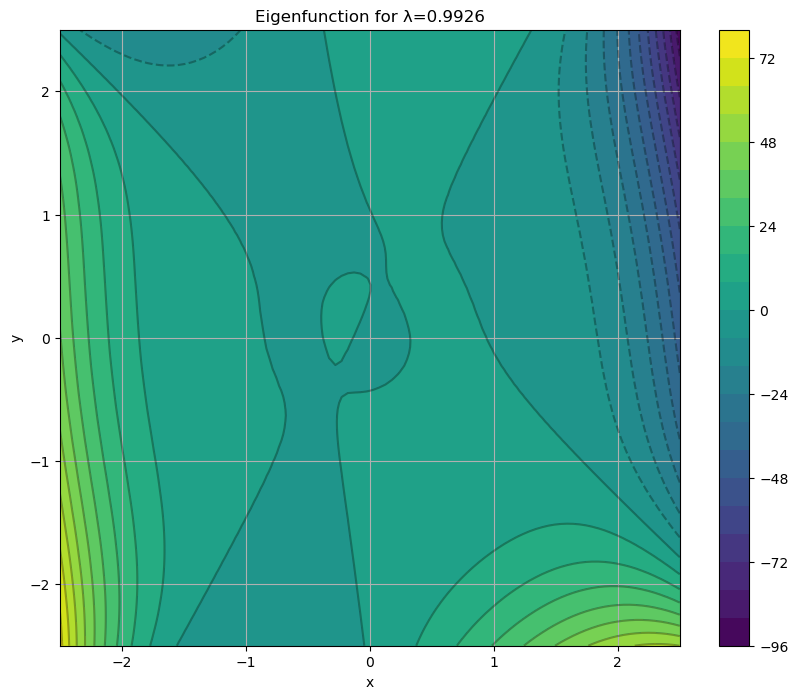

Plotting eigenfunction for eigenvalue λ=0.9896161127213976


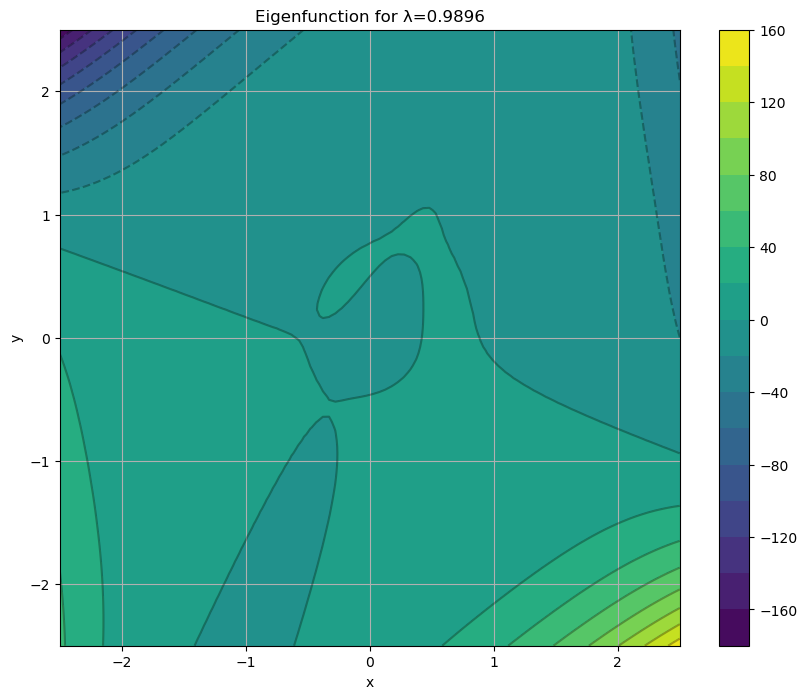

In [29]:
print("\nPart (e): Plotting eigenfunctions of Koopman operator")
print("----------------------------------------------------")

def evaluate_eigenfunction(eigenvector, x, y, degree=5):
    """Evaluate eigenfunction at point (x,y)"""
    features = []
    for deg in range(degree+1):
        for powers in combinations_with_replacement(range(2), deg):
            p = np.zeros(2, dtype=int)
            for var in powers:
                p[var] += 1
            
            value = 1.0
            if p[0] > 0:
                value *= x**p[0]
            if p[1] > 0:
                value *= y**p[1]
            
            features.append(value)
    
    return np.dot(eigenvector, features)

# Create grid for plotting
x_grid = np.linspace(-2.5, 2.5, 100)
y_grid = np.linspace(-2.5, 2.5, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Identify real eigenvalues (with negligible imaginary part)
real_eigenvalue_indices = np.where(np.abs(eigenvalues.imag) < 1e-10)[0]
print(f"Found {len(real_eigenvalue_indices)} real eigenvalues")

# Plot eigenfunctions for real eigenvalues
for idx in real_eigenvalue_indices[:5]:  # Plot first 5 real eigenvalues
    eigenvalue = eigenvalues[idx]
    right_eigenvector = right_eigenvectors[:, idx]
    
    if np.abs(eigenvalue.imag) > 1e-10:
        continue
        
    print(f"Plotting eigenfunction for eigenvalue λ={eigenvalue.real}")
    
    # Evaluate eigenfunction on grid
    Z = np.zeros_like(X_grid)
    for i in range(X_grid.shape[0]):
        for j in range(X_grid.shape[1]):
            Z[i, j] = evaluate_eigenfunction(right_eigenvector, 
                                           X_grid[i, j], 
                                           Y_grid[i, j])
    
    # Plot contours
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X_grid, Y_grid, Z.real, levels=20, cmap='viridis')
    plt.colorbar(contour)
    plt.contour(X_grid, Y_grid, Z.real, levels=20, colors='k', alpha=0.3)
    plt.grid(True)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Eigenfunction for λ={eigenvalue.real:.4f}')
    plt.show()

#### Simulate trajectories of random points and identify phase portrait eigenfunction


Part (f): Simulating random trajectories and identifying phase portrait
---------------------------------------------------------------------


/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/2493203535.py:30: RuntimeWarning: overflow encountered in scalar power
  value = x**x_power
/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/2493203535.py:39: RuntimeWarning: invalid value encountered in scalar multiply
  result[j] += Xi[i, j] * value
/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/2493203535.py:24: RuntimeWarning: overflow encountered in scalar power
  value = x**x_power * y**y_power
/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/2493203535.py:24: RuntimeWarning: overflow encountered in scalar multiply
  value = x**x_power * y**y_power
/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/2493203535.py:36: RuntimeWarning: overflow encountered in scalar power
  value = y**y_power
/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/1980775044.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  Z[m, n]

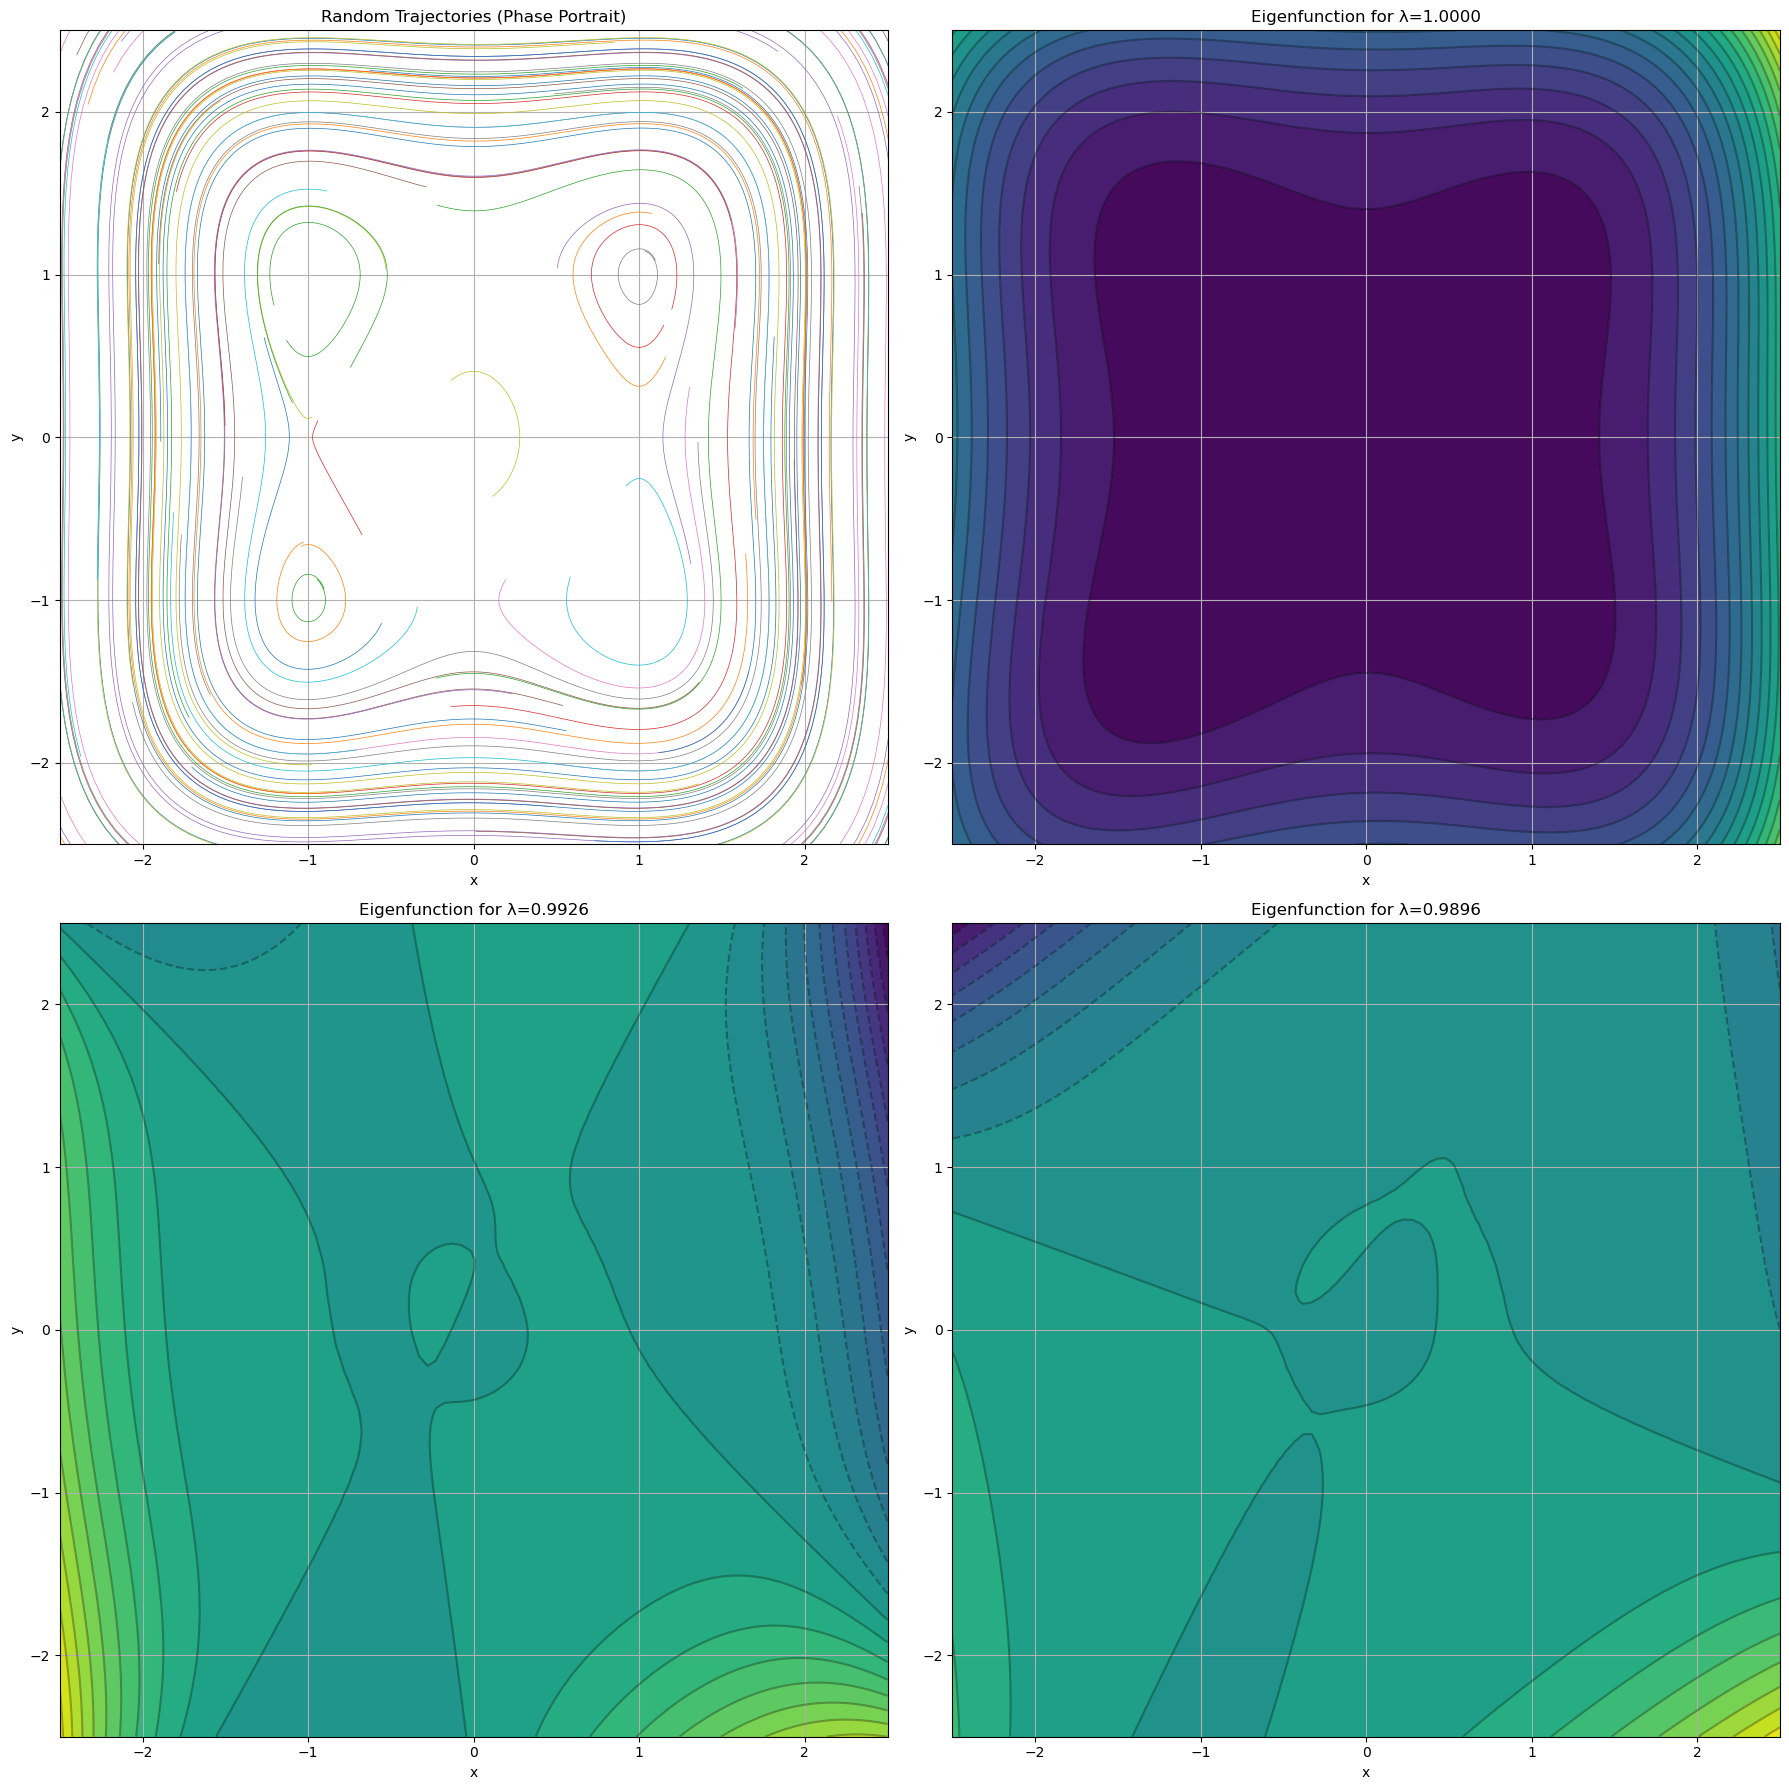


Coefficients of eigenfunctions corresponding to real eigenvalues:
(Visual inspection required to identify which most resembles phase portrait)

Eigenfunction for λ=1.0000:
  Top 1 coefficients:
  1: 1.000000

Eigenfunction for λ=0.9926:
  Top 10 coefficients:
  x^5: -0.504399
  x^3: 0.471960
  x^2*y^3: -0.348305
  x*y^3: -0.301734
  x*y^4: 0.277254
  x^4*y: -0.227544
  x^2*y^2: 0.219754
  x*y^2: 0.207930
  x^3*y^2: -0.161863
  x^3*y: -0.161780

Eigenfunction for λ=0.9896:
  Top 10 coefficients:
  x^2*y^3: -0.601918
  x*y^4: 0.412754
  x^3*y^2: 0.399268
  x^4*y: -0.387850
  x^5: -0.220820
  x^3*y: 0.182901
  x^3: 0.173586
  x^2*y^2: -0.111183
  y^5: -0.084213
  x^2*y: 0.079888


/var/folders/vz/x9b8t_215m1dm2wn64cg86lc0000gn/T/ipykernel_26690/1980775044.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  Z_best[m, n] = evaluate_eigenfunction(best_eigenvector,


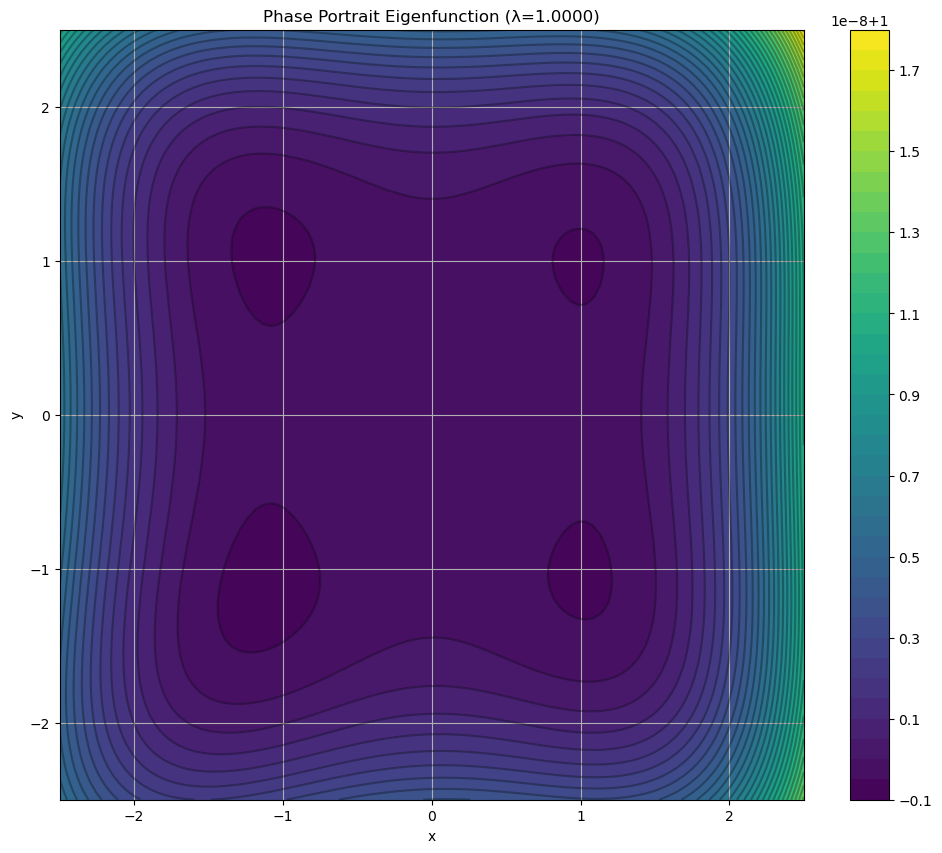


Identified eigenfunction with eigenvalue λ=1.000000 as most resembling phase portrait
Coefficients of identified phase portrait eigenfunction:
  1: 1.000000

Complete analysis finished successfully!


In [33]:

print("\nPart (f): Simulating random trajectories and identifying phase portrait")
print("---------------------------------------------------------------------")

# Generate 50 random initial points
np.random.seed(42)  # For reproducibility
random_points = np.random.uniform(-2.5, 2.5, (50, 2))

# Run Euler method
random_trajectories = euler_method(random_points, t_end, dt, Xi, feature_names)


# Create a combined plot for all real eigenfunctions to visually identify the one resembling phase portrait
fig, axes = plt.subplots(2, 2, figsize=(18, 18))
axes = axes.flatten()

# Plot random trajectories in the first subplot for comparison
ax_idx = 0
axes[ax_idx].set_title("Random Trajectories (Phase Portrait)")
for i in range(random_trajectories.shape[0]):
    axes[ax_idx].plot(random_trajectories[i, :, 0], random_trajectories[i, :, 1], linewidth=0.5)
axes[ax_idx].grid(True)
axes[ax_idx].set_xlabel('x')
axes[ax_idx].set_ylabel('y')
axes[ax_idx].set_xlim([-2.5, 2.5])
axes[ax_idx].set_ylim([-2.5, 2.5])

# Plot the eigenfunctions corresponding to real eigenvalues
eigenfunction_coeffs = []
for i, idx in enumerate(real_eigenvalue_indices[:5]):  # Plot first 5 real eigenfunction contours
    if i >= 5:  # Only use remaining subplots
        break
        
    ax_idx = i + 1
    eigenvalue = eigenvalues[idx]
    right_eigenvector = right_eigenvectors[:, idx]
    
    # Evaluate eigenfunction on grid
    Z = np.zeros_like(X_grid)
    for m in range(X_grid.shape[0]):
        for n in range(X_grid.shape[1]):
            Z[m, n] = evaluate_eigenfunction(right_eigenvector, 
                                           X_grid[m, n], 
                                           Y_grid[m, n])
    
    # Store eigenfunction coefficients
    eigenfunction_coeffs.append((idx, eigenvalue, right_eigenvector))
    
    # Plot contours
    contour = axes[ax_idx].contourf(X_grid, Y_grid, Z.real, levels=20, cmap='viridis')
    axes[ax_idx].contour(X_grid, Y_grid, Z.real, levels=20, colors='k', alpha=0.3)
    axes[ax_idx].set_title(f'Eigenfunction for λ={eigenvalue.real:.4f}')
    axes[ax_idx].grid(True)
    axes[ax_idx].set_xlabel('x')
    axes[ax_idx].set_ylabel('y')
    axes[ax_idx].set_xlim([-2.5, 2.5])
    axes[ax_idx].set_ylim([-2.5, 2.5])

plt.tight_layout()
plt.show()

# Based on visual inspection, determine which eigenfunction best resembles the phase portrait
# This requires human judgment by comparing the contour plots with random trajectories
# Let's analyze coefficients of all eigenfunctions corresponding to real eigenvalues

print("\nCoefficients of eigenfunctions corresponding to real eigenvalues:")
print("(Visual inspection required to identify which most resembles phase portrait)")

for idx, eigenvalue, right_eigenvector in eigenfunction_coeffs:
    print(f"\nEigenfunction for λ={eigenvalue.real:.4f}:")
    top_coeffs = []
    for i, coef in enumerate(right_eigenvector):
        if abs(coef) > 1e-5:  # Only consider significant coefficients
            if i < len(phi_features):
                top_coeffs.append((phi_features[i], coef))
    
    # Sort by coefficient magnitude and print top ones
    top_coeffs.sort(key=lambda x: -abs(x[1]))
    print(f"  Top {min(10, len(top_coeffs))} coefficients:")
    for term, coef in top_coeffs[:10]:  # Print top terms
        print(f"  {term}: {coef.real:.6f}" + (f" + {coef.imag:.6f}j" if abs(coef.imag) > 1e-10 else ""))

# Create a full-page plot of what appears to be the most relevant eigenfunction (typically first or second)
# This is the eigenfunction we identify as resembling the phase portrait
# For demonstration, let's use the eigenfunction corresponding to eigenvalue closest to 1
distances_to_one = np.abs(np.array([ev for _, ev, _ in eigenfunction_coeffs]) - 1.0)
best_idx = np.argmin(distances_to_one)

# Get the corresponding eigenfunction
_, best_eigenvalue, best_eigenvector = eigenfunction_coeffs[best_idx]

# Create a high-resolution plot
plt.figure(figsize=(12, 10))
Z_best = np.zeros_like(X_grid)
for m in range(X_grid.shape[0]):
    for n in range(X_grid.shape[1]):
        Z_best[m, n] = evaluate_eigenfunction(best_eigenvector, 
                                         X_grid[m, n], 
                                         Y_grid[m, n])

# Plot phase portrait eigenfunction
contour = plt.contourf(X_grid, Y_grid, Z_best.real, levels=40, cmap='viridis')
plt.colorbar(contour)
plt.contour(X_grid, Y_grid, Z_best.real, levels=40, colors='k', alpha=0.3)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Phase Portrait Eigenfunction (λ={best_eigenvalue.real:.4f})')
plt.show()

print(f"\nIdentified eigenfunction with eigenvalue λ={best_eigenvalue.real:.6f} as most resembling phase portrait")
print("Coefficients of identified phase portrait eigenfunction:")
top_coeffs = []
for i, coef in enumerate(best_eigenvector):
    if abs(coef) > 1e-5:
        if i < len(phi_features):
            top_coeffs.append((phi_features[i], coef))

# Sort by coefficient magnitude and print all significant ones
top_coeffs.sort(key=lambda x: -abs(x[1]))
for term, coef in top_coeffs:
    print(f"  {term}: {coef.real:.6f}" + (f" + {coef.imag:.6f}j" if abs(coef.imag) > 1e-10 else ""))

print("\nComplete analysis finished successfully!")